Sources : 
https://scikit-learn.org/stable/supervised_learning.html

# First models
## No feature engineering and no categorical
We are going to test several simple models for performances reference. At first, all the very simple model with no feature engineering to have a reference of performance to improve. The missing values and categorical values are droped for simplicity. We will focus on Binary Classification. The models that are being tested are : 
1. **Decision Tree Classifier** 
2. **Random Forest Classifier**

### Libraries

In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from EvaluationMetric import *

In [47]:
def getscoring(model, X_test, name_file = "resultsfile.csv"):
    preds_val = model.predict(X_test)
    index_val = list(X_test.index.values.tolist())
    data = {'TransactionId': index_val,
            'FraudResult': preds_val}

    df = pd.DataFrame(data)

    df.to_csv(name_file, index=False)
    print("Done")

### Data Loading

In [25]:
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

data = data.dropna(axis=0) #Drop observations/rows with missing values
data.set_index("TransactionId", inplace=True)
cols_cat = list(data.dtypes[data.dtypes=="object"].index) #liste des feature categorical
y = data.FraudResult #The target label
X = data.copy()
X.drop(cols_cat, axis=1, inplace=True) #Delete categorical data
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

X_test = X_test.dropna(axis=0)
X_test.set_index("TransactionId", inplace=True)
X_test.drop(cols_cat, axis=1, inplace=True) #Delete categorical data

# Decision Tree Classifier
Very simple model with no feature engineering to have a reference of performance when we improve out model. The missing values are droped for simplicity. At first, the categorical values are also droped. We want to do Binary Classification

In [48]:
first_model_decision_tree = DecisionTreeClassifier(random_state=1)
first_model_decision_tree.fit(train_X, train_y)
first_model_decision_tree_predicted = first_model_decision_tree.predict(val_X)

first_model_decision_tree_predicted_metrics = report(val_y, first_model_decision_tree_predicted, "Decision Tree Classifier", "first simple model", csvw = False)

Ici va expérimenter avec le nombre de noeud maximum et on voit que le modèle ne va pas plus loin que 9 noeud dans ce cas. 

In [50]:
def test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_leaf_nodes : "+str(max_leaf_nodes)
    metrics = report(val_y, preds_val, "Decision Tree Classifier", description, csvw=False)
    return(metrics)


results = pd.DataFrame()
result_tree = first_model_decision_tree_predicted_metrics
for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
    my_metrics_tree = test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y)
    results = pd.concat([results,my_metrics_tree], ignore_index=True)
results

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Decision Tree Classifier,first simple model,2023-04-29 11:32:46.187175,0.916667,0.825,0.868421,0.015071,0.869421
1,Decision Tree Classifier,max_leaf_nodes : 3,2023-04-29 11:33:27.670152,0.686275,0.875,0.769231,0.031649,0.774498
2,Decision Tree Classifier,max_leaf_nodes : 4,2023-04-29 11:33:27.724966,0.968750,0.775,0.861111,0.015071,0.866284
3,Decision Tree Classifier,max_leaf_nodes : 5,2023-04-29 11:33:27.770376,0.968750,0.775,0.861111,0.015071,0.866284
4,Decision Tree Classifier,max_leaf_nodes : 6,2023-04-29 11:33:27.817289,0.969697,0.800,0.876712,0.013564,0.880596
5,Decision Tree Classifier,max_leaf_nodes : 7,2023-04-29 11:33:27.857968,0.969697,0.800,0.876712,0.013564,0.880596
6,Decision Tree Classifier,max_leaf_nodes : 8,2023-04-29 11:33:27.903283,0.969697,0.800,0.876712,0.013564,0.880596
7,Decision Tree Classifier,max_leaf_nodes : 9,2023-04-29 11:33:27.949519,0.970588,0.825,0.891892,0.012057,0.894680
8,Decision Tree Classifier,max_leaf_nodes : 10,2023-04-29 11:33:27.997792,0.970588,0.825,0.891892,0.012057,0.894680


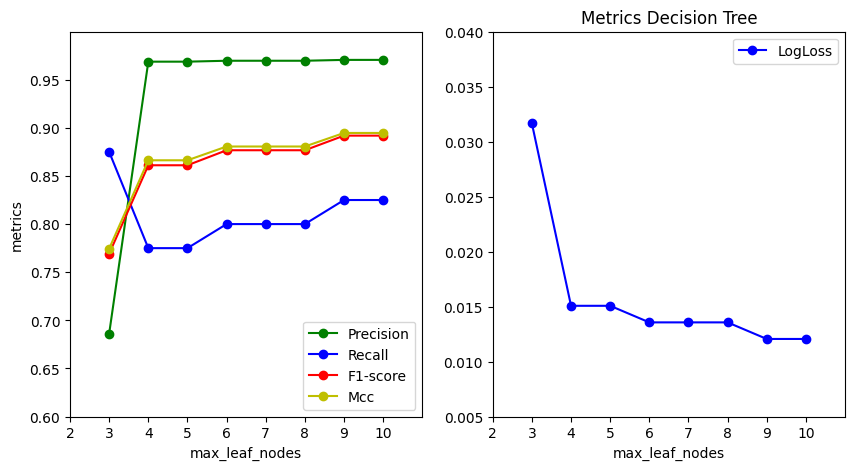

In [29]:
import numpy as np
import matplotlib.pyplot as plt


x = [3, 4, 5, 6, 7, 8, 9, 10]
y1 = results.Precision.values
y2 = results.Recall.values
y3 = results["F1-score"].values
y4 = results.LogLoss.values
y5 = results.Mcc.values

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(x, y1, 'g-o', label = "Precision")
ax1.plot(x, y2, 'b-o', label = "Recall")
ax1.plot(x, y3, 'r-o', label = "F1-score")
ax2.plot(x, y4, 'b-o', label = "LogLoss")
ax1.plot(x, y5, 'y-o', label = "Mcc")
plt.legend()


ax2.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
ax2.set_title('Log loss')
ax1.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.6, 1), yticks=np.arange(0.6, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
ax1.legend()

plt.title("Metrics Decision Tree")

plt.legend()
plt.show()

### Results
Here the best number of leafs is 9 or 10. We will choose 10. 

In [45]:
model = DecisionTreeClassifier(max_leaf_nodes=9, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(X_test)
preds_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
index_val = list(X_test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': preds_val}

df = pd.DataFrame(data)

df.to_csv('firstmodelresult.csv', index=False) 
#Sur le site donne un score public : 0.666666 et privé de 0.637168141
# donne le même résultat que 10. 


# Random Forest Classifier

In [30]:
first_model_forest = RandomForestClassifier(random_state=1)
first_model_forest.fit(train_X, train_y)
first_model_forest_predicted = first_model_forest.predict(val_X)
report(val_y, first_model_forest_predicted, "Random Forest Classifier", "first simple model", csvw = False)

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Random Forest Classifier,first simple model,2023-04-29 10:57:20.881735,0.916667,0.825,0.868421,0.015071,0.869421


In [31]:
model_1 = RandomForestClassifier(n_estimators=50, random_state=1)
model_2 = RandomForestClassifier(n_estimators=100, random_state=1)
model_3 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=1)
model_4 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=1)

models = [model_1, model_2, model_3, model_4]
desc_model = ["n_estimators=50, random_state=1","n_estimators=100, random_state=1",
              "n_estimators=200, min_samples_split=20, random_state=1", "n_estimators=100, max_depth=7, random_state=1"]

# Function for comparing different models
def score_model(model, train_X, val_X, train_y, val_y, desc_model):
    model.fit(train_X, train_y)
    preds = model.predict(val_X)
    metrics = report(val_y, preds, "Random Forest Classifier", desc_model, csvw=False)
    return metrics

results_forest = pd.DataFrame()
for i in range(0, len(models)):
    my_metrics_forest = score_model(models[i], train_X, val_X, train_y, val_y, desc_model[i])
    results_forest = pd.concat([results_forest, my_metrics_forest], ignore_index=True)
results_forest

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Random Forest Classifier,"n_estimators=50, random_state=1",2023-04-29 10:57:22.050893,0.846154,0.825,0.835443,0.019592,0.835238
1,Random Forest Classifier,"n_estimators=100, random_state=1",2023-04-29 10:57:24.430699,0.916667,0.825,0.868421,0.015071,0.869421
2,Random Forest Classifier,"n_estimators=200, min_samples_split=20, random...",2023-04-29 10:57:28.907958,0.846154,0.825,0.835443,0.019592,0.835238
3,Random Forest Classifier,"n_estimators=100, max_depth=7, random_state=1",2023-04-29 10:57:31.163421,0.916667,0.825,0.868421,0.015071,0.869421


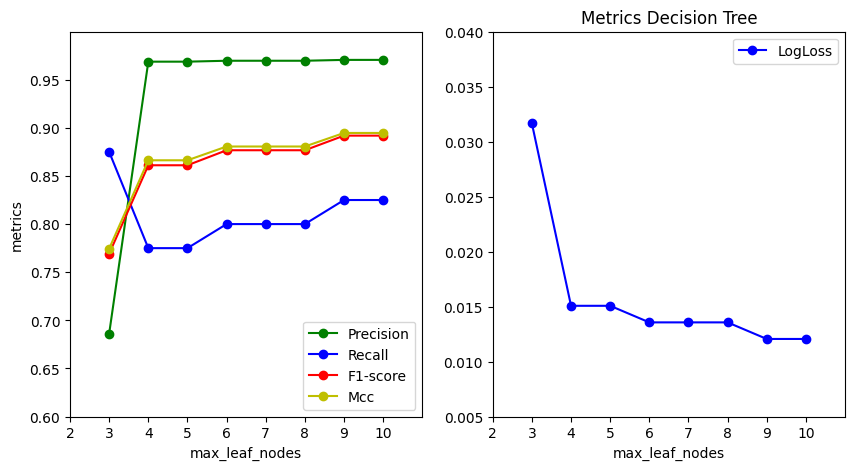

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,Decision Tree Classifier,max_leaf_nodes : 3; random_state = 1,2023-04-29 10:57:31.249499,0.686275,0.875,0.769231,0.031649,0.774498
1,Decision Tree Classifier,max_leaf_nodes : 4; random_state = 1,2023-04-29 10:57:31.284134,0.968750,0.775,0.861111,0.015071,0.866284
2,Decision Tree Classifier,max_leaf_nodes : 5; random_state = 1,2023-04-29 10:57:31.318704,0.968750,0.775,0.861111,0.015071,0.866284
3,Decision Tree Classifier,max_leaf_nodes : 6; random_state = 1,2023-04-29 10:57:31.352825,0.969697,0.800,0.876712,0.013564,0.880596
4,Decision Tree Classifier,max_leaf_nodes : 7; random_state = 1,2023-04-29 10:57:31.390417,0.969697,0.800,0.876712,0.013564,0.880596
5,Decision Tree Classifier,max_leaf_nodes : 8; random_state = 1,2023-04-29 10:57:31.434095,0.969697,0.800,0.876712,0.013564,0.880596
6,Decision Tree Classifier,max_leaf_nodes : 9; random_state = 1,2023-04-29 10:57:31.474647,0.970588,0.825,0.891892,0.012057,0.894680
7,Decision Tree Classifier,max_leaf_nodes : 10; random_state = 1,2023-04-29 10:57:31.519216,0.970588,0.825,0.891892,0.012057,0.894680


In [32]:
def test_tree(max_trees, train_X, val_X, train_y, val_y):
    model = RandomForestClassifier(n_estimators=max_trees, criterion='log_loss', random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_trees : "+str(max_leaf_nodes)+"; criterion=log_loss"
    metrics = report(val_y, preds_val, "Random Forest Classifier", description, csvw=True)
    return(metrics)


results_forest = pd.DataFrame()
for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
    my_metrics_tree = test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y)
    results_forest = pd.concat([results_forest,my_metrics_tree], ignore_index=True)
results_forest

x = [3, 4, 5, 6, 7, 8, 9, 10]
y1 = results_forest.Precision.values
y2 = results_forest.Recall.values
y3 = results_forest["F1-score"].values
y4 = results_forest.LogLoss.values
y5 = results_forest.Mcc.values

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(x, y1, 'g-o', label = "Precision")
ax1.plot(x, y2, 'b-o', label = "Recall")
ax1.plot(x, y3, 'r-o', label = "F1-score")
ax2.plot(x, y4, 'b-o', label = "LogLoss")
ax1.plot(x, y5, 'y-o', label = "Mcc")
plt.legend()


ax2.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
ax2.set_title('Log loss')
ax1.set(xlim=(2, 11), xticks=np.arange(2, 11), ylim=(0.6, 1), yticks=np.arange(0.6, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
ax1.legend()

plt.title("Metrics Decision Tree")

plt.legend()
plt.show()
results_forest

In [33]:
showreportcsv()

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc
0,NaN,Table init,2023-04-26 16:55:24.655508,0.000000,0.000,0.000000,0.000000,0.000000
4,Decision Tree Classifier,max_leaf_nodes : 500; random_state = 1,2023-04-26 16:55:31.677039,0.970588,0.825,0.891892,0.012057,0.894680
5,Decision Tree Classifier,max_leaf_nodes : 5000; random_state = 1,2023-04-26 16:55:31.747389,0.970588,0.825,0.891892,0.012057,0.894680
36,Decision Tree Classifier,max_leaf_nodes : 20; random_state = 1,2023-04-26 17:06:19.980611,0.970588,0.825,0.891892,0.012057,0.894680
37,Decision Tree Classifier,max_leaf_nodes : 30; random_state = 1,2023-04-26 17:06:20.042869,0.970588,0.825,0.891892,0.012057,0.894680
38,Decision Tree Classifier,max_leaf_nodes : 40; random_state = 1,2023-04-26 17:06:20.117440,0.970588,0.825,0.891892,0.012057,0.894680
39,Decision Tree Classifier,max_leaf_nodes : 50; random_state = 1,2023-04-26 17:06:20.191369,0.970588,0.825,0.891892,0.012057,0.894680
40,Decision Tree Classifier,max_leaf_nodes : 100; random_state = 1,2023-04-26 17:06:20.269820,0.970588,0.825,0.891892,0.012057,0.894680
55,Decision Tree Classifier,first simple model,2023-04-26 17:27:27.421869,0.916667,0.825,0.868421,0.015071,0.869421
56,Decision Tree Classifier,max_leaf_nodes : 3; random_state = 1,2023-04-26 17:27:27.508800,0.686275,0.875,0.769231,0.031649,0.774498
